In [14]:
!pip install torch
!pip install torch_geometric
!pip install -U sentence-transformers

In [ ]:
# !apt install libcairo2-dev libgif-dev
# !pip install pycairo
# # !pip install igraph

# # and one of these:
# !pip install cairocffi
# # !pip install cairocffi==0.9.0

In [354]:
import os

from IPython.lib.pretty import Text
import networkx as nx
from networkx.classes.digraph import DiGraph
import xml.etree.ElementTree as ET

import typing as tp

import matplotlib.pyplot as plt

import networkx
from sentence_transformers import SentenceTransformer
import torch

from torch_geometric.data import Data
from scipy.sparse import coo_matrix

import torch_geometric as tg


from tqdm import tqdm

In [4]:
def get_methods(tree: ET.ElementTree) -> tp.List[tp.Tuple[ET.Element, str]]:
    '''
    Extracting all MethodDeclaration nodes that have names starting with "good" or "bad" from XML tree
    '''
    methods = []

    for r in tree.findall("//SimpleName/..MethodDeclaration"):
        method_name = r.findtext('SimpleName')
        if method_name[:3] == 'bad' or method_name[:4] == 'good':
            methods.append((r, method_name))
        
    return methods

In [335]:
# FOR DEBUG ONLY
_NodeNames = ['CastExpression', 'ParenthesizedExpression', 'TryStmt', 'IfStatement', 'SimpleType', 'UnaryExpr', 'PackageDeclaration', 'DoStmt', 'BinaryExpr', 'LabeledStmt', 'ObjectCreationExpr', 'BreakStmt', 'QualifiedName', 'CastExpr', 'SingleMemberAnnotationExpr', 'AssertStmt', 'SuperExpr', 'MethodCallExpr', 'ArrayAccessExpr', 'NumberLiteral', 'ImportDeclaration', 'StringLiteral', 'NameExpr', 'EnumDeclaration', 'CatchClause', 'ClassOrInterfaceType', 'InfixExpression', 'PrimitiveType', 'MethodInvocation', 'VariableDeclarationStatement', 'MarkerAnnotationExpr', 'SingleVariableDeclaration', 'Modifier', 'BlockStmt', 'MemberValuePair', 'Block', 'FieldAccessExpr', 'ClassExpr', 'SynchronizedStmt', 'ContinueStmt', 'ThrowStmt', 'ForEachStmt', 'InstanceOfExpr', 'NormalAnnotationExpr', 'TryStatement', 'ArrayInitializerExpr', 'ForStatement', 'SwitchStmt', 'FieldDeclaration', 'VariableDeclarationFragment', 'Assignment', 'TypeDeclaration', 'PostfixExpression', 'LiteralExpr', 'ThisExpr', 'CaseStmt', 'WhileStmt', 'ConditionalExpr', 'ReturnStmt', 'ForStmt', 'ConstructorDeclaration', 'EnclosedExpr', 'ArrayAccess', 'ArrayType', 'ClassInstanceCreation', 'NullLiteral', 'Dimension', 'SimpleName', 'ClassOrInterfaceDeclaration', 'Expression', 'AssignExpr', 'VariableDeclarationExpression', 'VariableDeclarator', 'ExpressionStmt', 'CompilationUnit', 'AnnotationExpr', 'MethodDeclaration', 'IfStmt', 'VariableDeclarationExpr', 'ExpressionStatement']

shorted = {s:s[:2] + ''.join(ch for ch in s[2:] if ch.isupper()) for s in _NodeNames}
print(len(shorted.keys()), len(set(shorted.values())))
# with open('/content/ASTNodeNames.txt', 'w') as f:
#     for n in _NodeNames:
#       f.write(n + '\n')

80 73


In [387]:
# Building graph
def dfs_build_graph(root_node:ET.Element) -> tp.Tuple[DiGraph, tp.List, str]:
    graph = nx.DiGraph() 

    leafs = []
    root_name = 0
    suf = iter(range(10_000_000))

    def dfs(vertice:ET.Element, layer:int = 0) -> str:
        # Extract node name in AST
        # if vertice.tag not in shorted:
        #   print('UNSUPPORTED TAG:', vertice.tag)
        #   _NodeNames.append(vertice.tag)

        # tag = shorted[vertice.tag] # XML tag like <SimpleName>
        tag = vertice.tag # XML tag like <SimpleName>
        text = vertice.text.strip() # XML text like <> text </>, usually empty
        # if tag == 'SimpleName':
        #     text = str(hash(text))

        node = next(suf)
        node_name = tag      

        graph.add_node(node, text=node_name, color='#555' if layer != 0 else 'orange', layer=layer)
        
        # Recursively traverse the child nodes
        for child in vertice:
            child_node = dfs(child, layer + 1)
            graph.add_edge(child_node, node, color='gray')
          
        if len(vertice) == 0:
            leaf_node = next(suf)
            leaf_name = text
            graph.add_node(leaf_node, text=leaf_name, color='green', layer=layer + 1)
            graph.add_edge(leaf_node, node, color='gray')

            leafs.append(leaf_node)
            
        return node

    # TODO: add sink and leafs edges here, not outside
    
    dfs(root_node, 0)

    return (graph, leafs, root_name)

# Merging Single-Entry Node Sequences
def dfs_merge_sequences(graph, node: Text):
  # node: Text, key of node in graph.nodes

  nodes_one_succ = []

  while(graph.in_degree(node) == 1):
      nodes_one_succ.append(node)
      node = list(graph.predecessors(node))[0]

  # leaf nodes sholdn't be merged, so in_degree != 0

  if len(nodes_one_succ) > 1:
      parent = nodes_one_succ[0]

      for child in nodes_one_succ[1:]:
          nx.contracted_nodes(graph, parent, child, self_loops=False, copy=False)

      # concatenate tokens of merged vertices
      p = graph.nodes(data=True)[parent]
      p['text'] += ',' + ','.join(map(str, p['contraction'].keys()))

      del p['contraction']

  # now node is either a leaf or has degree >= 2

  for child in graph.predecessors(node):
      dfs_merge_sequences(graph, child)

# Merging Aggregation Structures
# TODO: merge only vertices with specific AST node names
def dfs_merge_aggregations(graph, node: Text):

    # Recursively traverse the child nodes
    children_degs = [graph.in_degree(child) for child in graph.predecessors(node)]
    
    if not children_degs:
        # node is a leaf
        return

    if len(children_degs) >= 2 and max(children_degs) <= 1: # TODO
        # all children are either have deg=1 or a leaf
        # merging node and children
        children = list(graph.predecessors(node))
        
        for child in (children):
            nx.contracted_nodes(graph, node, child, self_loops=False, copy=False)
        
        parent = graph.nodes(data=True)[node]
        parent['text'] += '|' + \
            '|'.join([args['text'] for args in parent['contraction'].values()])
        del parent['contraction']

    for child in graph.predecessors(node):
        dfs_merge_aggregations(graph, child)

In [386]:
def build_graph(root_node:ET.Element) -> DiGraph:
    
    graph, leafs, root_name = dfs_build_graph(root_node)

    dfs_merge_sequences(graph, root_name)
    dfs_merge_aggregations(graph, root_name)

    # Adding edges between leafs (consequent initial code tokens)
    for u, v in zip(leafs[:-1], leafs[1:]):
        graph.add_edge(u, v, color='purple')

    # Adding ROOT node - global graph's sink
    for v in graph.nodes:
        if v != root_name:
            graph.add_edge(v, root_name, color='#EEE')

    return graph


In [357]:
def get_graph_nodes_embedding(graph: DiGraph, model) -> torch.Tensor:
    # returns: torch.Tensor.shape = (len(graph.nodes), 768 or 384)  
    EMBEDDING_SIZE = model.get_sentence_embedding_dimension()

    embeddings_ = torch.zeros((len(graph.nodes), EMBEDDING_SIZE), dtype=torch.float)

    for i, (name, args) in enumerate(graph.nodes(data=True)):
        # print(args['text'])
        groups_1 = args['text'].split('|')
        for g1 in groups_1:
            groups_2 = g1.split(',')
            embeddings_[i] += model.encode(groups_2).mean(axis=0)
            
        embeddings_[i] /= len(groups_1)
    return embeddings_

In [358]:
def graph_to_data(graph:DiGraph, target:int, model) -> Data:
    # data = from_networkx(graph)
    # data.x = get_graph_nodes_embedding(graph, model)
    # data.y = target
    # return data

    # this is faster
    graph = nx.convert_node_labels_to_integers(graph)
    return Data(edge_index=torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous().view(2, -1),
                edge_attr=None,
                num_nodes=len(graph.nodes),
                x=get_graph_nodes_embedding(graph, model),
                y=target
                )

In [385]:
def xml_to_Data(
                path_to_xmls,
                show_plots=False, 
                save_plots=False, 
                path_to_images='/content/cags',
                MODEL_NAME='all-MiniLM-L6-v2' # https://www.sbert.net/docs/pretrained_models.html
                ) -> tp.Tuple[tp.List[Data], tp.List[DiGraph]]:

    model = SentenceTransformer('sentence-transformers/' + MODEL_NAME)
    
    datas = [] 
    graphs = []

    for filename in tqdm(os.listdir(path_to_xmls)):
        file_path = os.path.join(path_to_xmls, filename)
        if not os.path.isfile(file_path):
          continue

        tree = ET.parse(file_path)
        method_roots = get_methods(tree)

        for root_node, method_name in method_roots: 

            graph = build_graph(root_node)
            graphs.append(graph)
            target = 1 if method_name[:3] == 'bad' else 0
            data = graph_to_data(graph, target, model)

            datas.append(data)        

            if show_plots:
                style = {
                        "with_labels": True, 
                        "node_size": 12,
                        "font_size": 9,   
                        "edge_color": [(attrs.get('color')) or 'gray' for u, v, attrs in graph.edges(data=True)],
                        "node_color": [(attrs.get('color')) for n, attrs in graph.nodes(data=True)],
                        "labels": {n:(attrs.get('text')) for n, attrs in graph.nodes(data=True)},
                        "node_shape" : '8',
                        "pos": nx.multipartite_layout(graph, align='horizontal', subset_key="layer"),
                        # "pos": nx.spring_layout(graph, k=0.3)
                        }

                print(f'file:{filename}, method:{method_name}')
                nx.draw(graph, 
                        **style
                        )
                
                if save_plots:
                  plt.savefig(path_to_images + filename[:-4] + '_' + method_name + '.png')

                if show_plots:
                    plt.show()
            
    return [datas, graphs]       

# Начало тут


In [373]:
path_to_xmls = '/content/xml'
# path_to_xmls = '/content/xml_small'
# path_to_xmls = '/content/xml_medium'
# path_to_xmls = '/content/xml_large'

show_plots = False
save_plots = False
path_to_images = '/content/cags/'

# MODEL_NAME = 'all-mpnet-base-v2'
MODEL_NAME = 'all-MiniLM-L6-v2' # ~ 2 times faster, slightly worse quality


In [374]:
datas, graphs = xml_to_Data('/content/xml')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


In [378]:
datas, graphs = xml_to_Data('/content/xml')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


In [369]:
datas, graphs = xml_to_Data('/content/xml_medium')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


In [381]:
datas, graphs = xml_to_Data('/content/xml_medium')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


In [346]:
datas, graphs = xml_to_Data('/content/xml_large')

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 10/10 [03:11<00:00, 19.15s/it]


In [382]:
datas, graphs = xml_to_Data('/content/xml_large')

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 10/10 [03:09<00:00, 18.96s/it]


In [384]:
xml_to_Data('/content/xml_large')

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-4-2e0903426759>:4: FutureWarning: This search is broken in 1.3 and earlier, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/SimpleName/..MethodDeclaration'
  for r in tree.findall("//SimpleName/..MethodDeclaration"):
100%|██████████| 10/10 [03:14<00:00, 19.49s/it]


[[], []]

In [347]:
print(f'Total graphs: {len(graphs)}')

Total graphs: 44


In [348]:
datas[-10:]

[Data(x=[644, 384], edge_index=[2, 1576], y=1, num_nodes=644),
 Data(x=[449, 384], edge_index=[2, 1094], y=0, num_nodes=449),
 Data(x=[839, 384], edge_index=[2, 2058], y=0, num_nodes=839),
 Data(x=[12, 384], edge_index=[2, 22], y=0, num_nodes=12),
 Data(x=[439, 384], edge_index=[2, 1071], y=1, num_nodes=439),
 Data(x=[245, 384], edge_index=[2, 593], y=0, num_nodes=245),
 Data(x=[245, 384], edge_index=[2, 593], y=0, num_nodes=245),
 Data(x=[445, 384], edge_index=[2, 1088], y=0, num_nodes=445),
 Data(x=[440, 384], edge_index=[2, 1075], y=0, num_nodes=440),
 Data(x=[14, 384], edge_index=[2, 28], y=0, num_nodes=14)]

In [349]:
index = -1

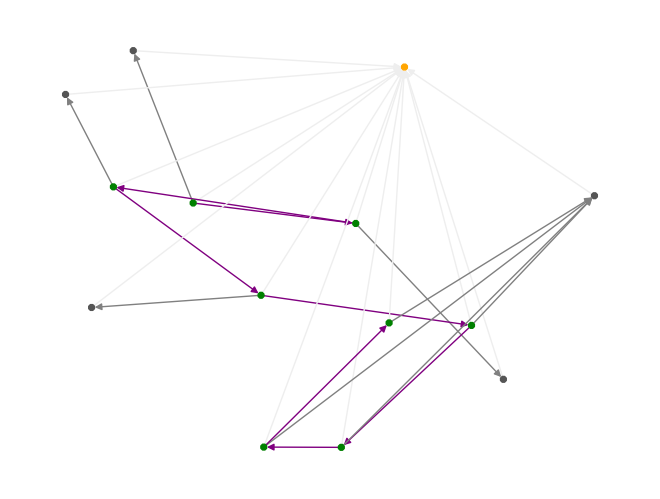

In [350]:
graph = graphs[index]
style = {
          # "with_labels": True, 
          "node_size": 20,
          "font_size": 9,   
          "edge_color": [(attrs.get('color')) or 'gray' for u, v, attrs in graph.edges(data=True)],
          "node_color": [(attrs.get('color')) for n, attrs in graph.nodes(data=True)],
          # "labels": {n:(attrs.get('text')) for n, attrs in graph.nodes(data=True)},
          "node_shape" : '8',
          # "pos": nx.multipartite_layout(graph, align='horizontal', subset_key="layer")
          }
nx.draw(graph, **style)

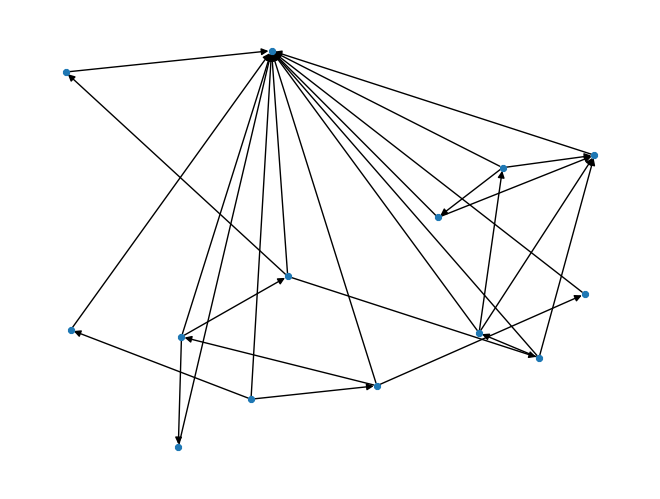

In [351]:
d = datas[index]
gr = tg.utils.to_networkx(d)
style = {
          # "with_labels": True, 
          "node_size": 20,
          "font_size": 9,   
          # "edge_color": [(attrs.get('color')) or 'gray' for u, v, attrs in graph.edges(data=True)],
          # "node_color": [(attrs.get('color')) for n, attrs in graph.nodes(data=True)],
          # "labels": {n:(attrs.get('text')) for n, attrs in graph.nodes(data=True)},
          "node_shape" : '8',
          # "pos": nx.multipartite_layout(graph, align='horizontal', subset_key="layer")
          }
nx.draw(gr, **style)